<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/01-banners_bayes_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-arm bandits for banners (tf-agents)

In [ ]:
pip install -q tf-agents

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import List, Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from scipy.stats import beta
from tf_agents.agents import tf_agent
from tf_agents.bandits.environments import bandit_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.typing import types

## Environment

In [ ]:
class BannerEnvironment(bandit_py_environment.BanditPyEnvironment):

  def __init__(self, ctrs: List[float]):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=len(ctrs) - 1, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.float32, minimum=0., maximum=1., name='observation')
    
    self.ctrs = ctrs

    super(BannerEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.rand(1)
    return self._observation

  def _apply_action(self, action):
    return self.ctrs[action] > self._observation[0]

In [ ]:
environment = tf_py_environment.TFPyEnvironment(BannerEnvironment([0.25, 0.4, 0.67]))
observation = environment.reset()
print(f'observation: {observation.observation}')

action =  2#@param
print(f'action: {action}')

reward = environment.step(action).reward
print(f'reward: {reward}')

observation: [[0.73067406]]
action: 2
reward: [0.]


## Policy

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
class BetaPolicy(tf_policy.TFPolicy):
  def __init__(self, alpha: List[int], beta: List[int]):

    assert len(alpha) == len(beta), 'Alpha and Beta does not have same size'

    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=len(alpha) - 1)
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.float64, minimum=0., maximum=1)
    time_step_spec = ts.time_step_spec(observation_spec)
    
    self._alpha = alpha
    self._beta = beta
    
    super(BetaPolicy, self).__init__(time_step_spec=time_step_spec, 
                                     action_spec=action_spec)
    
  def _distribution(self, time_step: ts.TimeStep) -> policy_step.PolicyStep:
    pass

  def _variables(self) -> Sequence[tf.Variable]:
    return [self._alpha, self._beta]

  def _action(
      self, 
      time_step: ts.TimeStep, 
      policy_state: types.NestedTensor = (), 
      seed: Optional[types.Seed] = None) -> policy_step.PolicyStep:
    sample = tfd.Beta(self._alpha, self._beta).sample()
    action = tf.cast(tf.reshape(tf.math.argmax(sample), [1]), dtype=tf.int32)

    return policy_step.PolicyStep(action, policy_state)

Let's tests the behaviour of the policy.

In [ ]:
policy = BetaPolicy([10, 1, 1], [1, 1, 1])

observation = tf.ones(policy.time_step_spec.observation.shape, dtype=tf.float64)
print(f'observation: {observation}')
time_step = ts.restart(observation)

action = policy.action(time_step).action
print(f'action: {action}')

observation: [1.]
action: [0]


## Agent

In [ ]:
class BetaAgent(tf_agent.TFAgent):
  def __init__(self):
    self._alpha = [1, 1, 1]
    self._beta = [1, 1, 1]

    policy = BetaPolicy(self._alpha, self._beta)
    time_step_spec = policy.time_step_spec
    action_spec = policy.action_spec

    super(BetaAgent, self).__init__(time_step_spec=time_step_spec,
                                    action_spec=action_spec,
                                    policy=policy,
                                    collect_policy=policy,
                                    train_sequence_length=None)

  def _initialize(self) -> Optional[tf.Operation]:
    return tf.compat.v1.variables_initializer(self.variables)

  def _train(
      self, 
      experience: types.NestedTensor, 
      weights: Optional[types.Tensor] = None) -> tf_agent.LossInfo:
    # Get all necessary info from the trajectory
    observation = experience.observation
    action = experience.action
    reward = experience.reward
    # Get the action value, which represents the 
    # index of the used Beta distribution.
    dist_index = action.numpy()[0, 0]
    # Updated proper parameters of the 
    # distribution based on the reward.
    if tf.cast(reward, dtype=tf.bool):
      self._alpha[dist_index] += 1
    else:
      self._beta[dist_index] += 1

    return tf_agent.LossInfo((), ())

## Experiment

In [ ]:
# We need to add another dimension here because the agent expects the
# trajectory of shape [batch_size, time, ...], but in this tutorial we assume
# that both batch size and time are 1. Hence all the expand_dims.

def trajectory_for_bandit(initial_step, action_step, final_step) -> types.NestedTensor:
  return trajectory.Trajectory(observation=tf.expand_dims(initial_step.observation, 0),
                               action=tf.expand_dims(action_step.action, 0),
                               policy_info=action_step.info,
                               reward=tf.expand_dims(final_step.reward, 0),
                               discount=tf.expand_dims(final_step.discount, 0),
                               step_type=tf.expand_dims(initial_step.step_type, 0),
                               next_step_type=tf.expand_dims(final_step.step_type, 0))

def plot_pdf(a: List[int], b: List[int]):
  fig, ax = plt.subplots(1, 1)
  x = np.linspace(beta.ppf(0.01, a, b),
                  beta.ppf(0.99, a, b), 100)

  ax.plot(x, beta.pdf(x, a, b),
        '-', lw=1, alpha=0.6, label='beta pdf')

In [ ]:
environment = tf_py_environment.TFPyEnvironment(BannerEnvironment([0.25, 0.4, 0.67]))
step = environment.reset()

agent = BetaAgent()

for _ in range(500):
  action_step = agent.collect_policy.action(step)  
  next_step = environment.step(action_step.action)  
  # Create trajectory nested 
  experience = trajectory_for_bandit(step, action_step, next_step)
  # Train policy in the agent
  agent.train(experience)
  step = next_step

print(f'\nalpha={agent._alpha}, beta={agent._beta}')
print(f'mu={beta.stats(agent._alpha, agent._beta)[0]}')


alpha=ListWrapper([1, 17, 319]), beta=ListWrapper([6, 18, 145])
mu=[0.14285714 0.48571429 0.6875    ]


We can plot the estimates of the CTR distributions after policy training.

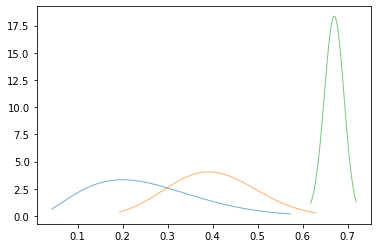

In [ ]:
plot_pdf(agent._alpha, agent._beta)